# **Data**

<br>

## **Simulated data used here is representative of actual quality improvement project**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,hour_of_day,method,duration
0,13,control,117.969829
1,15,control,106.665437
2,9,new,97.036785
3,13,control,107.906207
4,3,new,70.665614


<br>

## **Team compared duration between new method and control method**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

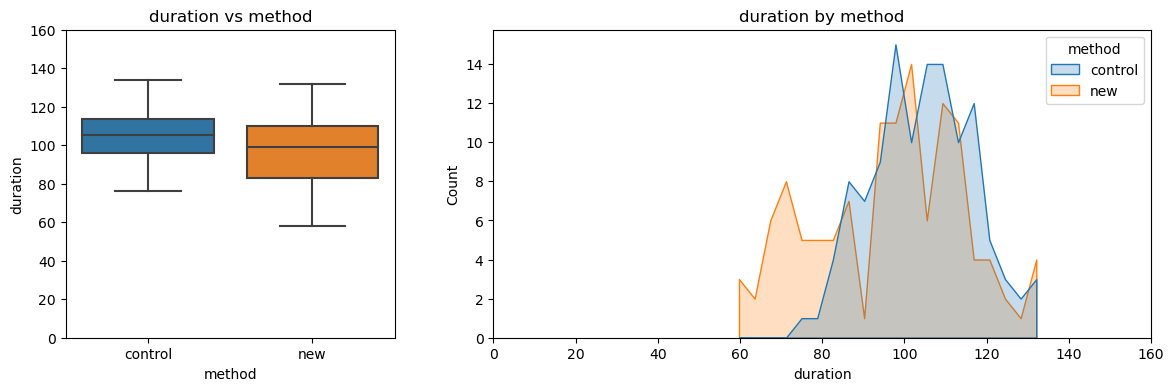

In [5]:
figure, axis = plt.subplots(1, 2, figsize=(14,4), width_ratios=[1,2])

sns.boxplot(x=df['method'], y=df['duration'], ax=axis[0])
axis[0].set_title('duration vs method')
axis[0].set_ylim(ymin=0, ymax=160)

sns.histplot(x=df['duration'], hue=df['method'], element='poly', bins=20, ax=axis[1])
axis[1].set_title('duration by method')
axis[1].set_xlim(xmin=0, xmax=160);

#### **(a) Duration using new method was not significantly reduced compared to control method.**
#### **(b) This means quality improvement project did not achieve objective.**

<br>

## **What's next for team?**
#### **Choice 1. Find out why new method did not work (learn from failures)**
#### **Choice 2. Design another new method to pilot**
<br>

## **Decision**
#### **We decided to take Choice 1 using Hierarchical Clustering**

<br>

## **Step 1: Encode 'method' to 'method_transformed' so model can accept it as input**

In [6]:
from sklearn import preprocessing

In [7]:
label_encoder = preprocessing.LabelEncoder()

In [8]:
df['method_transformed'] = label_encoder.fit_transform(df['method'])

In [9]:
df.head()

,hour_of_day,method,duration,method_transformed
0,13,control,117.969829,0
1,15,control,106.665437,0
2,9,new,97.036785,1
3,13,control,107.906207,0
4,3,new,70.665614,1


<br>

## **Step 2: Scale 'hour_of_day' and 'duration' using Standard-Normal**

In [10]:
standard_scaler = preprocessing.StandardScaler()

In [11]:
df2 = standard_scaler.fit_transform(df.drop(['method','method_transformed'], axis=1))

In [12]:
df2[:10]

array([[ 0.22151996,  1.10325527],
       [ 0.52883089,  0.40292911],
       [-0.3931019 , -0.1935822 ],
       [ 0.22151996,  0.47979689],
       [-1.31503469, -1.82732081],
       [ 0.22151996, -0.37459522],
       [ 0.68248636,  1.44293545],
       [ 1.14345276,  0.44859146],
       [-1.00772376, -2.06796816],
       [-1.46869016, -2.60763049]])

#### **Note that df2 is an array, not a dataframe**

<br>

## **Step 3: Add 'method_transformed' back to the array**

In [13]:
import numpy as np

In [14]:
df2 = np.append(df2, df['method_transformed'].to_numpy().reshape(-1,1), axis=1)

In [15]:
df2[:10]

array([[ 0.22151996,  1.10325527,  0.        ],
       [ 0.52883089,  0.40292911,  0.        ],
       [-0.3931019 , -0.1935822 ,  1.        ],
       [ 0.22151996,  0.47979689,  0.        ],
       [-1.31503469, -1.82732081,  1.        ],
       [ 0.22151996, -0.37459522,  1.        ],
       [ 0.68248636,  1.44293545,  0.        ],
       [ 1.14345276,  0.44859146,  0.        ],
       [-1.00772376, -2.06796816,  1.        ],
       [-1.46869016, -2.60763049,  1.        ]])

<br>

## **Step 4: Convert array back to dataframe as input to hierarchical clustering model**

In [16]:
df2 = pd.DataFrame(df2, columns=df.drop(['method'], axis=1).columns)

In [17]:
df2.head()

,hour_of_day,duration,method_transformed
0,0.221520,1.103255,0.0
1,0.528831,0.402929,0.0
2,-0.393102,-0.193582,1.0
3,0.221520,0.479797,0.0
4,-1.315035,-1.827321,1.0


In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [19]:
linkage_data = linkage(df2, method='ward', metric='euclidean')

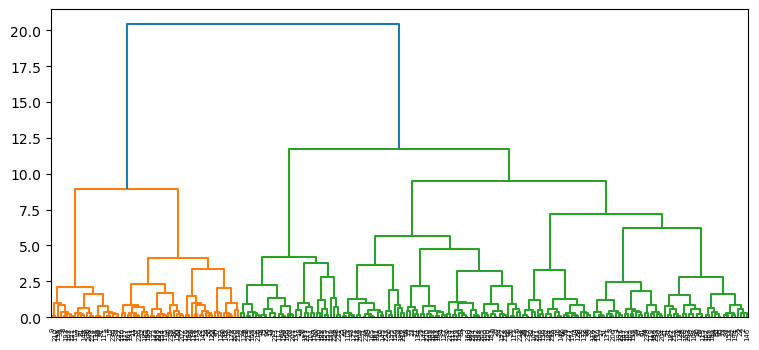

In [20]:
figure, axis = plt.subplots(figsize=(9,4))
dendrogram(linkage_data)
plt.show();

<br>

## **Step 5: From dendrogram, we decided to cut off at 2 clusters**

In [21]:
cluster_labels = cut_tree(linkage_data, n_clusters=2).reshape(-1,1)

#### **What is a Dendrogram?**

#### **https://www.displayr.com/what-is-dendrogram/**

<br>

## **Step 6: Add clusters back to dataframe for analysis**

In [22]:
df['cluster'] = pd.DataFrame(cluster_labels)

In [23]:
df.head()

,hour_of_day,method,duration,method_transformed,cluster
0,13,control,117.969829,0,0
1,15,control,106.665437,0,0
2,9,new,97.036785,1,0
3,13,control,107.906207,0,0
4,3,new,70.665614,1,1


<br>

## **Step 7: Compare 'hour_of_day', 'duration', 'method' in each cluster**

In [24]:
df1 = pd.pivot_table(df, index=['cluster','method'], values='hour_of_day', aggfunc='count').reset_index().rename_axis(None, axis=1).rename(columns={'hour_of_day':'count'})
df1

,cluster,method,count
0,0,control,86
1,0,new,89
2,1,control,32
3,1,new,33


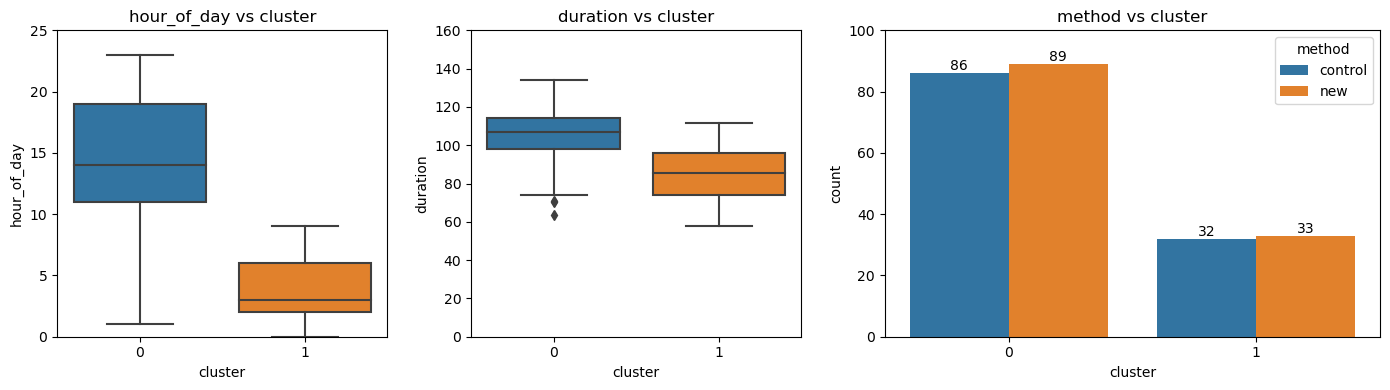

In [25]:
figure, axis = plt.subplots(1, 3, figsize=(14,4), width_ratios=[1,1,1.5])

sns.boxplot(x=df['cluster'], y=df['hour_of_day'], ax=axis[0])
axis[0].set_title('hour_of_day vs cluster')
axis[0].set_ylim(0, 25)

sns.boxplot(x=df['cluster'], y=df['duration'], ax=axis[1])
axis[1].set_title('duration vs cluster')
axis[1].set_ylim(0, 160)

sns.barplot(x=df1['cluster'], y=df1['count'], hue=df1['method'].replace({0: 'control', 1: 'new'}), ax=axis[2])
for i in axis[2].containers:
    axis[2].bar_label(i,)
axis[2].set_title('method vs cluster')
axis[2].set_ylim(0, 100)

plt.tight_layout(w_pad=2);

#### **(a) Cluster 1 has more early hours.**
#### **(b) Cluster 1 has shorter duration.**
#### **(c) Both clusters have comparable count of new and control methods.**
#### **Next step from (a) and (b): Compare duration by hour of day and method.**

<br>

## **Step 8: Compare duration by hour of day and method**

In [26]:
df['period'] = df.apply(lambda x: '00-08' if x['hour_of_day'] <= 7 else '08-00', axis=1)

In [27]:
df.head()

,hour_of_day,method,duration,method_transformed,cluster,period
0,13,control,117.969829,0,0,08-00
1,15,control,106.665437,0,0,08-00
2,9,new,97.036785,1,0,08-00
3,13,control,107.906207,0,0,08-00
4,3,new,70.665614,1,1,00-08


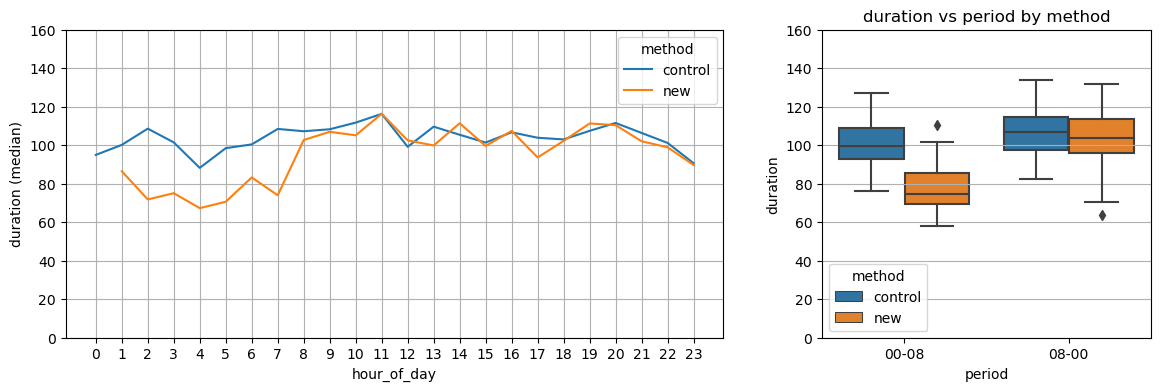

In [28]:
import numpy as np

figure, axis = plt.subplots(1, 2, figsize=(14,4), width_ratios=[2,1])

sns.lineplot(x=df['hour_of_day'], y=df['duration'], hue=df['method'].replace({0: 'control', 1: 'new'}), ax=axis[0], estimator=np.median, errorbar=None)
axis[0].set_xticks(np.arange(0,24,1))
axis[0].set_xticklabels(df.sort_values(by="hour_of_day")['hour_of_day'].unique())
axis[0].set_ylim(0, 160)
axis[0].set_ylabel('duration (median)')
axis[0].xaxis.grid()
axis[0].yaxis.grid()

sns.boxplot(x=df['period'], y=df['duration'], hue=df['method'].replace({0: 'control', 1: 'new'}), order=['00-08', '08-00'], ax=axis[1])
axis[1].set_title('duration vs period by method')
axis[1].set_ylim(0, 160)
axis[1].yaxis.grid();

#### **Indeed, new method has shorter duration in early hours**

<br>

## **Conclusion:**
## **From this exercise, you can see that data science can be used in quality improvement to quickly gain insight into a problem. This insight is the 'why'.**

<br>

## **You can go further using Linear Regression, which I will not discuss here**

In [29]:
from statsmodels.formula.api import ols

In [30]:
lr = ols(formula='duration ~ period + method + period*method', data=df)

In [31]:
lr_result = lr.fit()

In [32]:
print(lr_result.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     43.13
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           2.93e-22
Time:                        10:14:18   Log-Likelihood:                -955.63
No. Observations:                 240   AIC:                             1919.
Df Residuals:                     236   BIC:                             1933.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     